<a href="https://colab.research.google.com/github/ajmd2/Jinling-Enlightenment/blob/main/rl/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

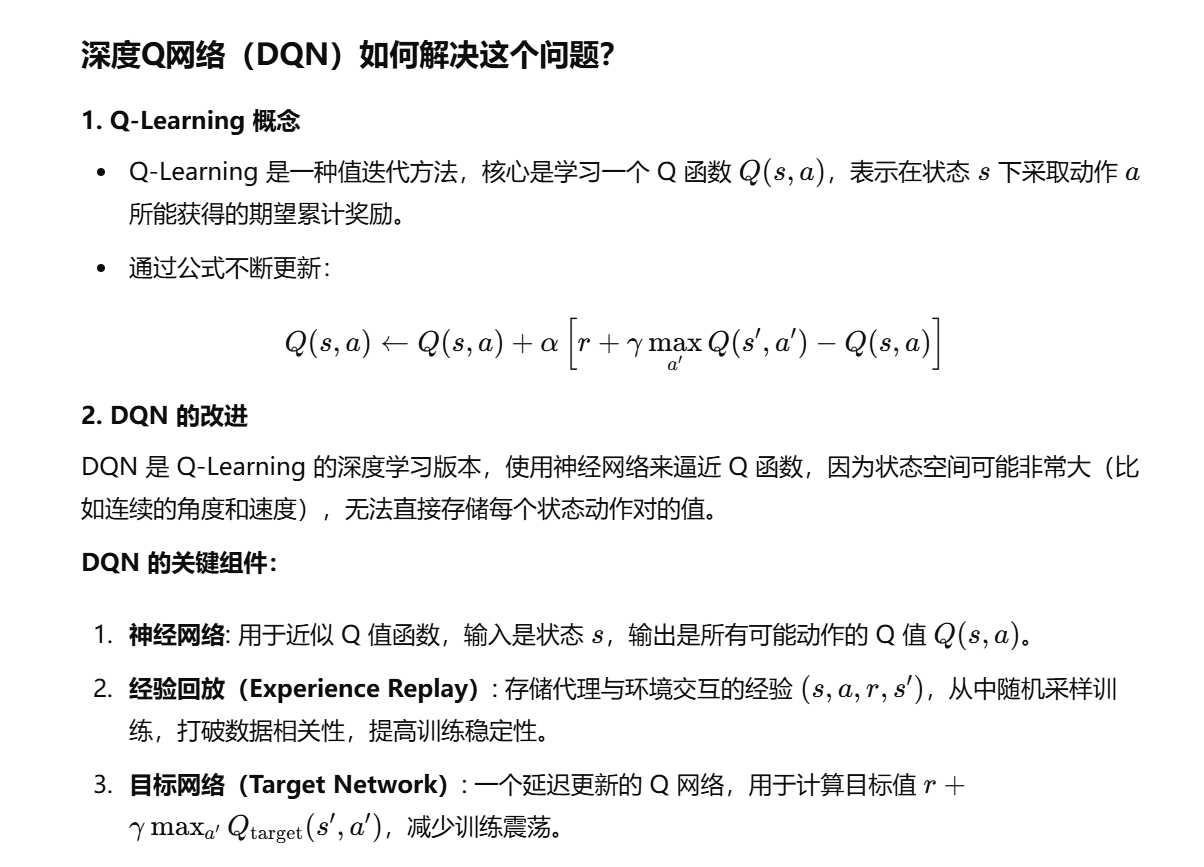

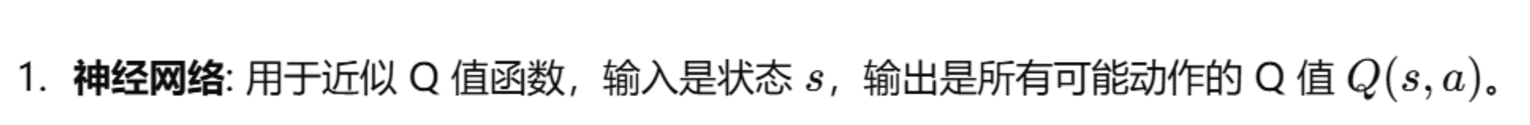

解释target的由来

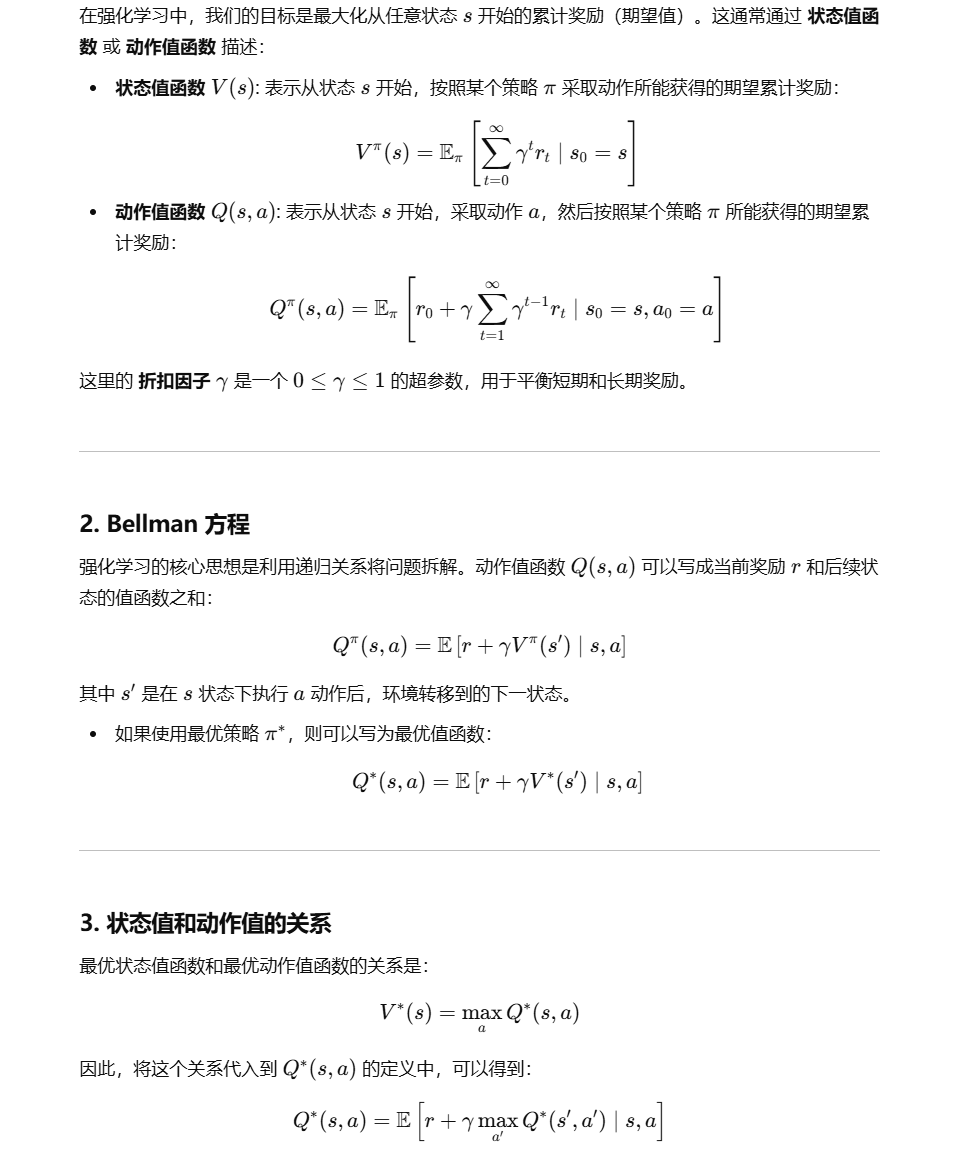

DQN使用神经网路计算Q

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for

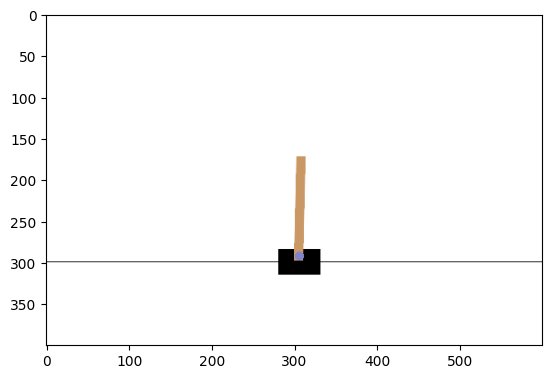

In [1]:
import gym
import os
from matplotlib import pyplot as plt
%matplotlib inline

os.environ["SDL_VIDEODRIVER"]='dummpy'

env = gym.make('CartPole-v0')

env.reset()

plt.imshow(env.render(mode='rgb_array'))
plt.show()

env.close()

分别表示下方车的位置，车的速度，上方杆的角度和杆的角速度

In [2]:
def test_env():
  state = env.reset()

  print('state=',state)

  print('env.action_space=',env.action_space)

  action = env.action_space.sample()

  print('action=',action)

  state,reward, over, _ = env.step(action)

  print('state=',state)

  print('reward=',reward)

  print('over=',over)

test_env()

state= [-0.02507249  0.02149541  0.0407386   0.03456085]
env.action_space= Discrete(2)
action= 1
state= [-0.02464258  0.2160102   0.04142982 -0.2449954 ]
reward= 1.0
over= False


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [3]:
import torch

model = torch.nn.Sequential(
    torch.nn.Linear(4,128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,2)
)


next_model = torch.nn.Sequential(
    torch.nn.Linear(4,128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,2)
)

# 把model的参数复制给 next_model
next_model.load_state_dict(model.state_dict())

model,next_model

(Sequential(
   (0): Linear(in_features=4, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=2, bias=True)
 ),
 Sequential(
   (0): Linear(in_features=4, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=2, bias=True)
 ))

对应下面的两个pi网络结构

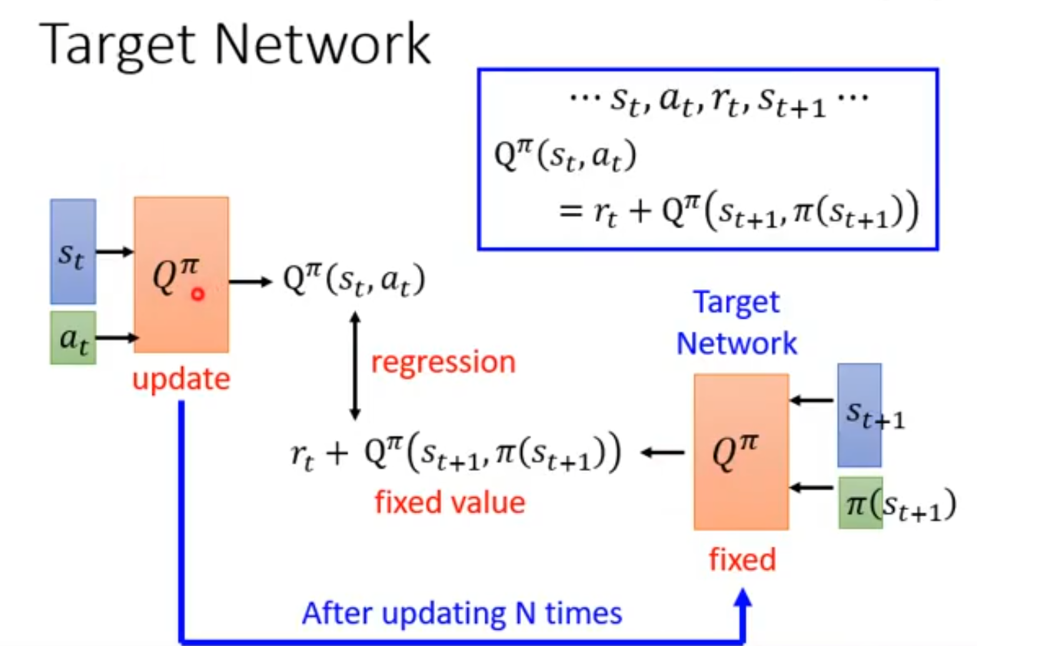

In [4]:
import random

def get_action(state):
  if random.random() <0.01:
    return random.choice([0,1])# 只有两个动作 0，1

  state = torch.FloatTensor(state).reshape(1,4)

  return model(state).argmax().item()

get_action([0.0312552, 0.02998468, 0.04875583, -0.04489201])

0

更新数据样本池函数准备离线学习

In [5]:
datas = []

def up_data():
  old_count = len(datas)

  while len(datas) - old_count < 200:
    state = env.reset()

    over = False
    while not over:

      action = get_action(state)

      next_state, reward ,over, _ = env.step(action)

      datas.append((state,action,reward,next_state,over))

      state = next_state

  update_count = len(datas) - old_count
  drop_count = max(len(datas)-10000,0)

  while len(datas)>10000:
    datas.pop(0)

  return update_count, drop_count

up_data()


(211, 0)

In [6]:
def get_sample():
  samples = random.sample(datas, 64)

  state = torch.FloatTensor([ i[0] for i in samples]).reshape(-1,4)

  action = torch.LongTensor([i[1] for i in samples]).reshape(-1,1)

  reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1,1)

  next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1,4)

  over = torch.FloatTensor([i[4] for i in samples]).reshape(-1,1)

  return state, action, reward , next_state, over

state, action, reward, next_state, over = get_sample()


<ipython-input-6-c55883b6b6fc>:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  state = torch.FloatTensor([ i[0] for i in samples]).reshape(-1,4)


In [7]:
def get_value(state, action):
  value = model(state)

  value = value.gather(dim=1,index = action)

  return value

get_value(state,action).shape

torch.Size([64, 1])

In [8]:
def get_target(reward,next_state,over):

  with torch.no_grad():
    target = next_model(next_state)

  target = target.max(dim=1)[0]
  target = target.reshape(-1,1)


  target *= 0.98

  target *=(1-over)

  target += reward

  return target


In [9]:
from IPython import display

def test(play):
  state = env.reset()

  reward_sum = 0

  over = False
  while not over:
    action = get_action(state)
    state,reward, over,_ = env.step(action)
    reward_sum += reward

    if play and random.random() < 0.2:
      display.clear_output(wait = True)
      show()
  return reward_sum

test(play = False)

22.0

In [11]:
def train():
  model.train()
  optimizer = torch.optim.Adam(model.parameters(),lr = 2e-3)
  loss_fn = torch.nn.MSELoss()

  for epoch in range(500):
    #更新N条数据
    update_count, drop_count = up_data()

    for i in range(200):
      state, action, reward ,next_state, over = get_sample()

      value = get_value(state,action)
      target  = get_target(reward, next_state,over)
      loss = loss_fn(value,target)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (i+1)%10 == 0:
        next_model.load_state_dict(model.state_dict())

    if epoch % 50 == 0:
      test_result = sum([test(play=False) for _ in range(20)]) /20
      print(epoch,len(datas),update_count,drop_count,test_result)
train()


0 648 232 0 9.5
50 10000 289 289 175.25
100 10000 200 200 198.5
150 10000 200 200 198.15
200 10000 200 200 196.25
250 10000 333 333 175.55
300 10000 200 200 193.8
350 10000 200 200 195.25
400 10000 200 200 102.45
450 10000 200 200 200.0


DQN 玩倒立摆

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning

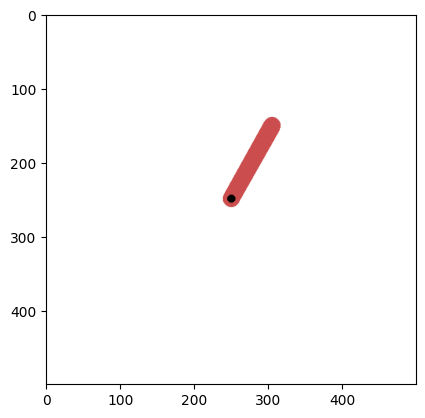

In [ ]:
import gym
from matplotlib import pyplot as plt
%matplotlib inline

env = gym.make('Pendulum-v1')
env.reset()


def show():
  plt.imshow(env.render(mode= 'rgb_array'))
  plt.show()

show()

In [ ]:
def test_env():
  state = env.reset()
  print('state=',state)
  print('env.action_space=',env.action_space)

  action = env.action_space.sample() # 倒立摆的动作是-2到2 的无穷多数字
  print('action=',action)

  state,reward,over,_ = env.step(action)
  print("next_all",state,reward,over)
test_env()

state= [0.73788613 0.6749252  0.28637788]
env.action_space= Box(-2.0, 2.0, (1,), float32)
action= [1.3683337]
next_all [0.7033092 0.7108841 0.9978218] -0.5589520496370796 False


测试环境，创建模型

In [ ]:
import torch

model = torch.nn.Sequential(
    torch.nn.Linear(3,128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,11),
)


next_model = torch.nn.Sequential(
    torch.nn.Linear(3,128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,11),
)

next_model.load_state_dict(model.state_dict())

model, next_model

(Sequential(
   (0): Linear(in_features=3, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=11, bias=True)
 ),
 Sequential(
   (0): Linear(in_features=3, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=11, bias=True)
 ))

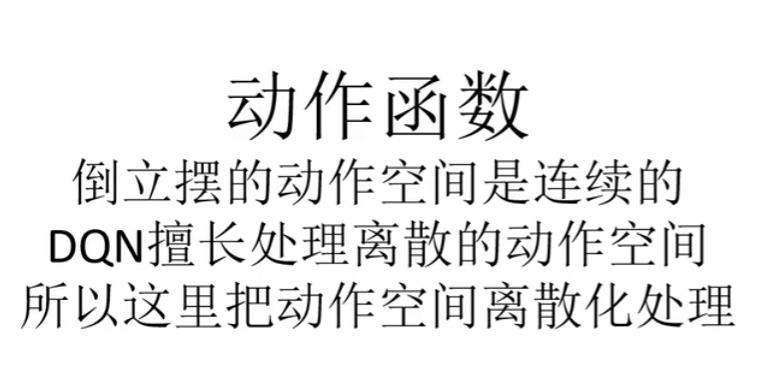

In [ ]:
import random

def get_action(state):
  state = torch.FloatTensor(state).reshape(1,3)
  action = model(state).argmax().item()

  if random.random() < 0.01:
    action = random.choice(range(11))


  action_continous = action
  action_continous /=10
  action_continous *=4
  action_continous -=2

  return action, action_continous

get_action()

更新数据样本池函数准备离线学习

In [ ]:
datas = []


def update_data():
  old_count = len(datas)

  while len(datas) - old_count < 200:

    state = env.resnet()

    over = False

    while not over:
      action, action_continuous = get_action(state)
      next_state, reward, over,_ = env.step([action_continuous])

      datas.append((state,action,reward,next_state,over))

      state = next_state


  update_count = len(datas) - old_count
  drop_count = max(len(datas)-5000,0)

  while len(datas) > 5000:
    datas.pop(0)

  return update_count, drop_count



后续代码基本一致不再书写，下面是sarsa到sars的解释



---

### **SARSA 的机制**
1. **SARSA** 全称是 **State-Action-Reward-State-Action**，它在更新 Q 值时依赖于：
   - 当前状态 $ s $ 和动作 $ a $。
   - 下一状态 $ s' $ 和 **实际策略下选择的下一动作** $ a' $。
   - 更新公式：
     $
     Q(s, a) \gets Q(s, a) + \alpha \left[ r + \gamma Q(s', a') - Q(s, a) \right]
     $
   - $ Q(s', a') $ 是 **当前策略** 选出的动作 $ a' $ 对应的 Q 值。

2. **特点**：
   - SARSA 是 **on-policy（基于策略的）**，即它直接根据当前的策略选择下一步动作 $ a' $。
   - 行为更加保守，因为它依赖于当前策略可能的下一步。

---

### **Q-Learning 和 DQN 的区别**
1. **Q-Learning 和 DQN** 不需要使用实际策略选出的下一动作 $ a' $，而是直接假设在下一状态 $ s' $ 中采取了 **最优动作** $ a'_{\text{max}} $。这个动作是通过选择 Q 值最大的动作来确定的：
   $
   Q(s, a) \gets Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]
   $
   - 这里，$ \max_{a'} Q(s', a') $ 是下一状态中所有可能动作的 Q 值的最大值。

2. **特点**：
   - **Q-Learning 和 DQN 是 off-policy（无策略的）**，因为它们直接使用最优值 $ \max_{a'} Q(s', a') $，而不是遵循当前的策略。
   - 更具探索性（因为它直接基于最优假设进行更新），能够找到全局最优解。

---

### **核心区别：`next_action` 的使用**
| 算法         | 是否需要 `next_action` | 用什么替代 `next_action`              | 策略性质     |
|--------------|-------------------------|---------------------------------------|--------------|
| **SARSA**    | 是，需要 `next_action`  | 当前策略的下一步动作 \( a' \)           | **on-policy**|
| **Q-Learning** | 否，不需要 `next_action` | 下一状态 \( s' \) 的最优动作 \( a'_{\text{max}} \) | **off-policy**|
| **DQN**      | 否，不需要 `next_action` | 下一状态 \( s' \) 的最优动作（通过神经网络计算） | **off-policy**|

- **SARSA**：需要明确知道下一步动作 \( a' \)，通常通过策略选择 \( a' \)。
- **Q-Learning 和 DQN**：不需要具体的下一步动作 \( a' \)，直接用下一状态中所有动作的最优值（最大值）替代。

---

### **为什么 Q-Learning 和 DQN 不需要 `next_action`？**

1. **核心思想**：
   - 在 SARSA 中，`next_action` 是当前策略的结果，因此更新与策略强相关。
   - 在 Q-Learning 和 DQN 中，它们假设代理总是选择最优动作 \( \max_{a'} Q(s', a') \)，因此不需要 `next_action`，可以直接替代为最优值。

2. **优点**：
   - 避免了直接依赖当前策略，从而能更好地探索和更新全局最优解。
   - 更适合复杂的任务和高维环境（特别是 DQN）。

3. **实现上的简化**：
   - 在 Q-Learning 和 DQN 中，不需要像 SARSA 那样专门计算或存储 `next_action`。

---

### **总结**
- SARSA 需要 `next_action` 来计算下一步的 Q 值，因为它基于当前策略（on-policy）。
- Q-Learning 和 DQN 用下一状态中 **可能的最优动作（最大 Q 值）** 代替了 `next_action`，这使得它们更独立于当前策略（off-policy）。
- 换句话说，在 Q-Learning 和 DQN 中，不需要明确的下一步动作，而是用 **假设的最优动作** 进行更新。

double DQN 改进点 主要是防止target的过高估计(课程中分析了)

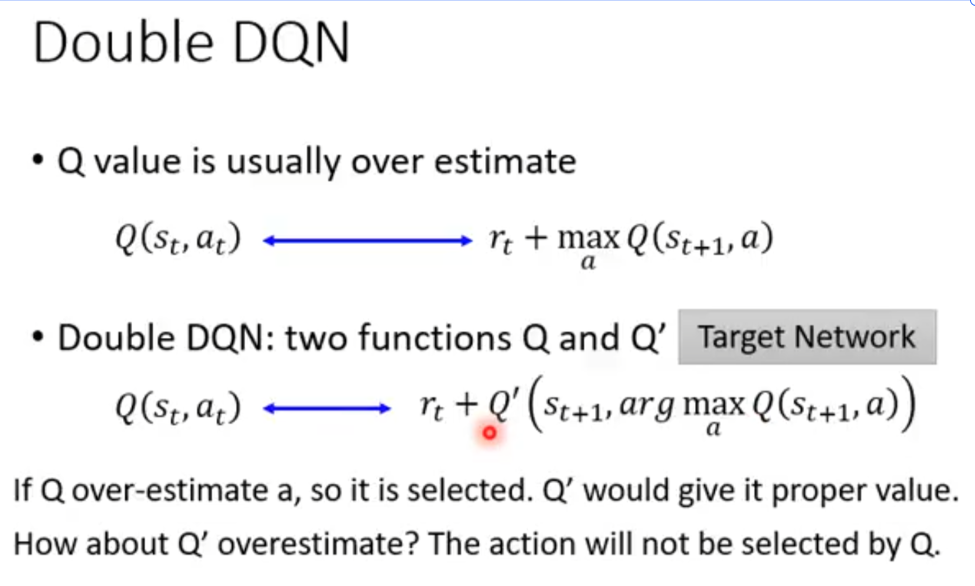

In [ ]:
def get_double_target(reward,next_state,over):
  with torch.no_grad():
    target = next_model(next_state)

  with torch.no_grad():
    model_target = model(next_state)

  model_target = model_target.max(dim=1)[1]
  model_taeget = model_target.reshape(-1,1)

  target = target.gather(dim=1,index=model_target)

  target *= 0.98

  target *= (1-over)

  return target


# def get_target(reward,next_state,over):

#   with torch.no_grad():
#     target = next_model(next_state)

#   target = target.max(dim=1)[0]
#   target = target.reshape(-1,1)


#   target *= 0.98

#   target *=(1-over)

#   target += reward

#   return target


你的理解非常接近，但稍微有点需要调整的地方。**Double DQN** 的核心思想是为了减少 Q 值的 **过估计问题**，通过两个网络分开 **动作选择** 和 **动作价值计算** 的任务。具体解释如下：

---

### **Double DQN 的机制**

在标准 DQN 中，更新 Q 值的目标是：
$
y = r + \gamma \max_{a'} Q_{\text{target}}(s', a')
$
其中，\(\max_{a'} Q_{\text{target}}(s', a')\) 是通过目标网络直接从所有动作中选取最大的 Q 值。

#### **过估计问题**
- 在 DQN 中，使用同一个网络既选择动作又计算动作价值（即使用最大 Q 值直接作为目标）。
- 这种做法容易导致 **过估计**，因为 Q 网络的预测可能有偏差，最大值操作会放大这个偏差。

#### **Double DQN 的解决方案**
Double DQN 的核心思想是 **将动作选择和动作价值的计算分开**，具体更新公式为：
$
y = r + \gamma Q_{\text{target}}(s', \arg\max_{a'} Q_{\text{main}}(s', a'))
$
1. **动作选择**（$\arg\max_{a'}$：
   - 由 **主网络 $ Q_{\text{main}} $** 决定，即主网络负责在下一状态 $ s' $ 中选择 Q 值最大的动作 $ a^* = \arg\max_{a'} Q_{\text{main}}(s', a') $。
2. **动作价值计算**（目标值）：
   - 由 **目标网络 \( Q_{\text{target}} \)** 计算，具体是目标网络根据主网络选择的动作 $ a^* $ 来计算对应的 Q 值 $ Q_{\text{target}}(s', a^*) $。

---

### **直观理解**
1. 在 **Double DQN** 中：
   - 一个网络（主网络 $ Q_{\text{main}} $）负责选择最优动作。
   - 另一个网络（目标网络 $ Q_{\text{target}} $）负责计算这些动作的 Q 值。
2. 分开这两步操作可以减少偏差，因为动作选择和动作价值估计分别由两个网络完成，避免了单个网络可能产生的高估。

---

### **总结**
你的理解基本正确：
1. 一个网络（主网络）决定 **哪个动作可能性最大**（通过 $\arg\max$ 操作选择动作）。
2. 另一个网络（目标网络）决定 **该动作的价值**（计算 Q 值）。

但更精确地说，两个网络的角色是：
- **主网络**：选择动作。
- **目标网络**：计算主网络选出的动作的 Q 值。

这种设计的核心目的是减少标准 DQN 中的过估计问题，从而提高算法的稳定性和性能。

Dueling DQN 改进点使用不同的模型

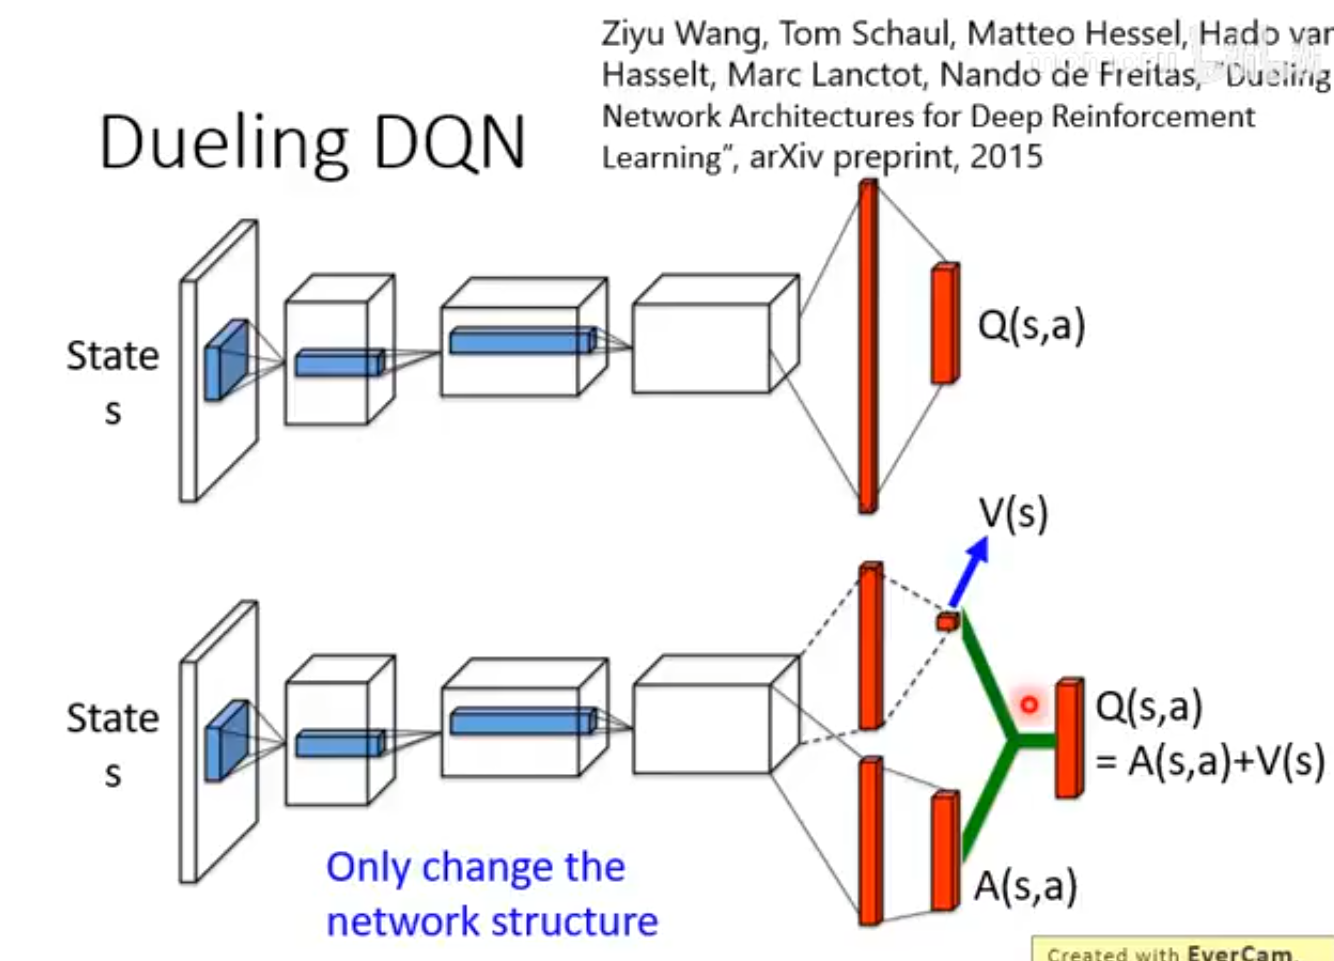

In [14]:
import torch

class VAnet(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.fc = torch.nn.Sequnential(
        torch.nn.Linear(3,128),
        torch.nn.ReLU(),
    )

    self.fc_A = torch.nn.Linear(128,11)
    self.fc_V = torch.nn.Linear(128,1)

  def forward(self,x):

    A = self.fc_A(self.fc(x))

    V = self.fc_V(self.fc(x))

    A_mean = A_mean(dim=1).reshape(-1,1)

    A -= A_mean

    Q = A+V

    return Q

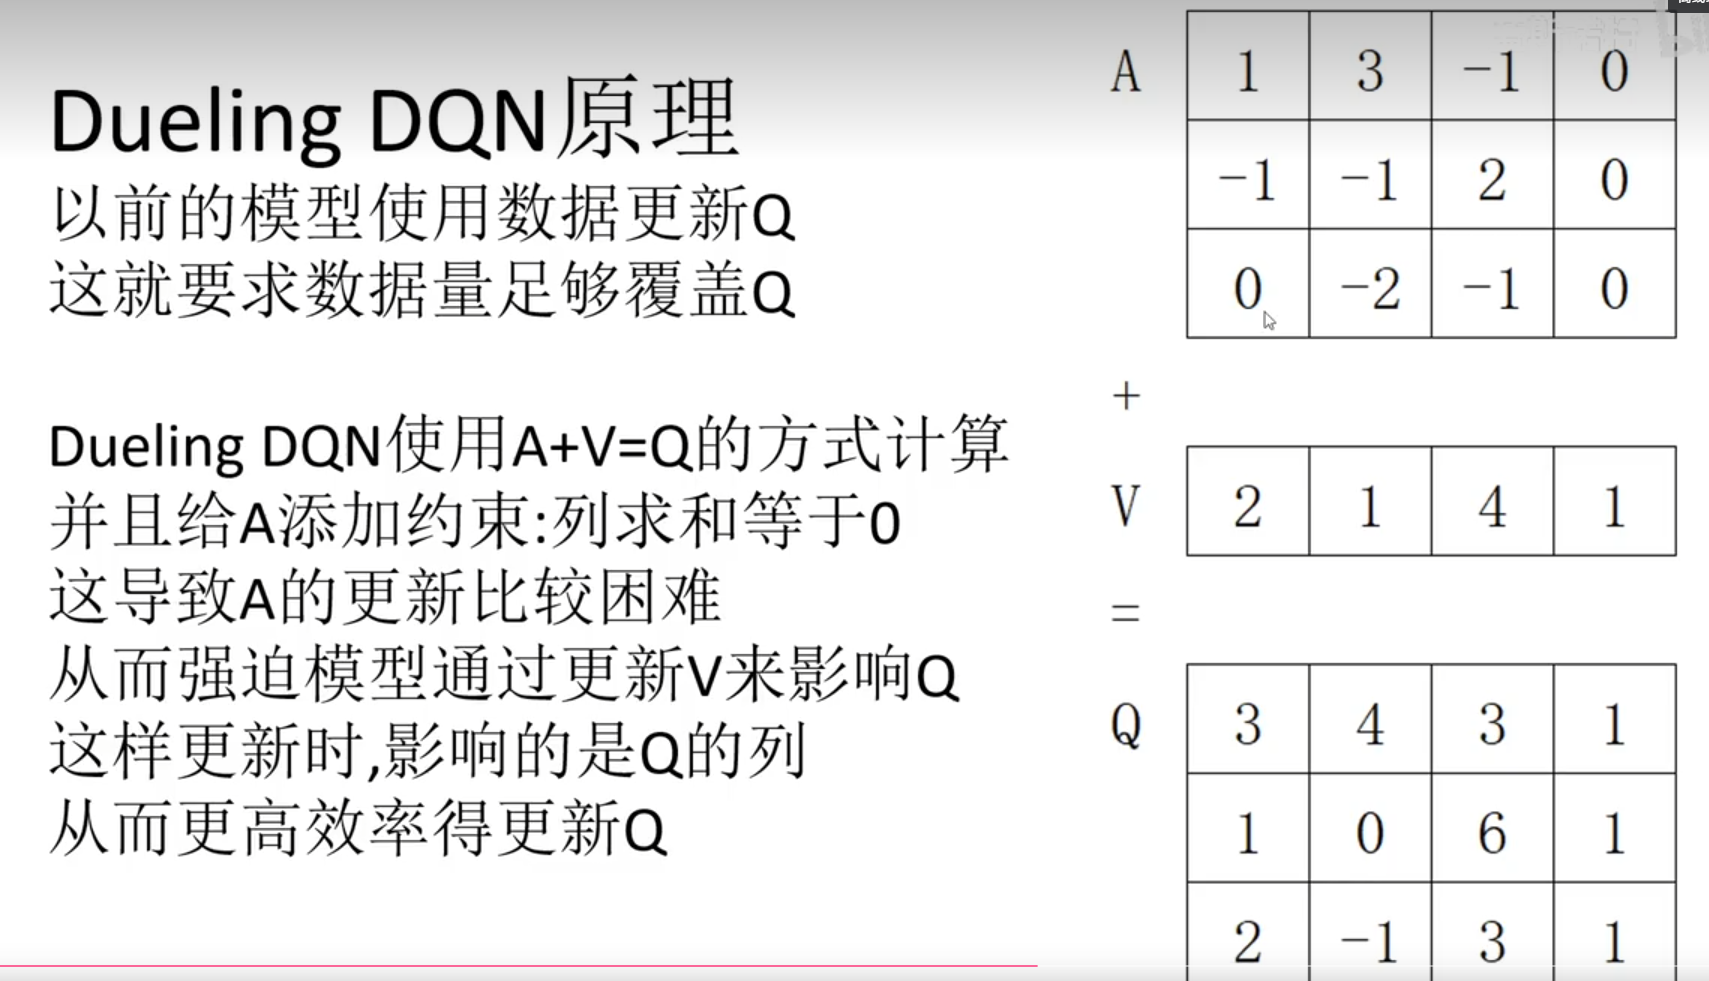

有的时候sample不一定到所有的action，所以使用A+V=Q,要给A加约束(课程7我还没听懂)

同时和PPO中的优势函数有联系